* By: David Munoz Constantine
* Email: dmunoz.dmc@gmail.com
* References: __Lewandowski, Kurowicka, and Joe (2009)__. __Joe (2006)__

-------
## Abstract

There is great interest in fast and efficient methods to generate positive-semidefinite financial correlation matrices. Some methods have a higher computational requirement and experience slow-downs as the dimension of the correlation matrix to generate increases. Lewandowski, Kurowicka, and Joe (2009) devised three methods based on a statistical tool called a 'vine' and on partial correlations to generate these matrices that greatly decrease the time to generate a correlation matrix.



## Correlation Matrices

Financial correlation matrices are constructed by using the correlation of stock returns over a time frame. Pearson's correlation coefficient is most commonly used. It is defined as

$p_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$

Where $p$ is the correlation coefficient, $cov$ is the covariance. $\sigma_X$ is the standard deviation of $X$. $\sigma_Y$ is the standard deviation of $Y$

Note that the Pearson's correlation only captures linear effects. If two variables have a strong non-linear dependency (squared or abs for example)
the Pearson correlation won't find any pattern between them. There are other methods to measure codependence not covered here. For more information, check our documentation and implementations of Codependence.

Correlation matrices are useful for risk management, asset allocation, hedging instrument selection, pricing models, etc. For example, in mean-variance optimization
of portfolios, risk and return are measured by the variance and mean of the portfolio returns. One way to calculate the variance of a portfolio is by using the
covariance matrix of those returns. Usually, this covariance matrix is estimated from historical data, which makes it subject to estimation errors and bias.
The relationship between correlation and covariance is shown above.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import yfinance as yf
from mlfinlab.data_generation.vines import (sample_from_cvine, sample_from_dvine, sample_from_ext_onion)

np.random.seed(2814)

## Vines

A vine is a graphical tool for modeling dependence structures of high-dimensional probability distributions.
Copulas are multivariate distributions with uniform univariate margins. It examines the association or dependence between many variables.

Vines have been proven to be useful and flexible tools in high-dimensional correlation structure modeling.
They consist of a nested set of connected trees where the edges in one tree are the nodes of another tree, and the edges of that tree are the nodes of a third tree and so on. In finance, vines have been shown to effectively model tail risk.

According to Zhu and Welsch (2018), they are defined as:

$V$ is an R-vine on $p$ elements with $E(V) = E_1 \cup ... \cup E_{p-1}$ denoting a set of edges of $V$ if:

- $V = {T_1, ..., T_{p-1}}$
- $T_1$ is a connected tree with nodes $N_1 = {1, ..., p}$, and edges $E_1$
- For $i = 2, ..., p-1$; $T_i$ is a tree with nodes $N_i = E_{i-1}$

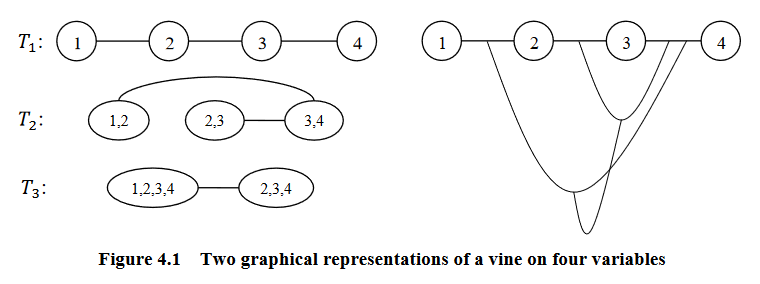

In [2]:
Image(filename='images/vine_example.png')


The most common vine structures are regular vines (R-vines,) canonical vine (C-vines,) and drawable vines (D-vines).
The following examples are based on the work of Zhu and Welsch (2018).

#### R-Vines


A vine is considered a regular vine on $p$ elements with $E(V) = E_1 \cup ... \cup E_{p-1}$
denoting the set of edges of $V$ if:

- $V$ is a vine
- For $i = 2, ..., p-1$; ${a, b} \in E_i$; $\#(a \Delta b) = 2$. Where $\Delta$ denotes the symmetric difference operator, and $\#$ denotes the cardinality of a set. Therefore, $a \Delta b = (a \cup b) \setminus (a \cap b)$

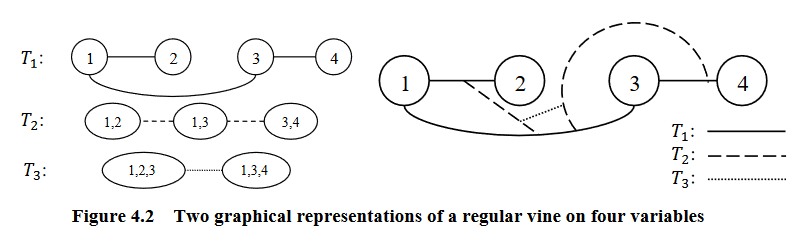

In [3]:
Image(filename='images/r_vine_example.png')

#### C-Vines


An R-vine is considered a C-vine if each tree $T_i$ has a unique node of degree $p-i$
for $i = 1, ..., p-2$.

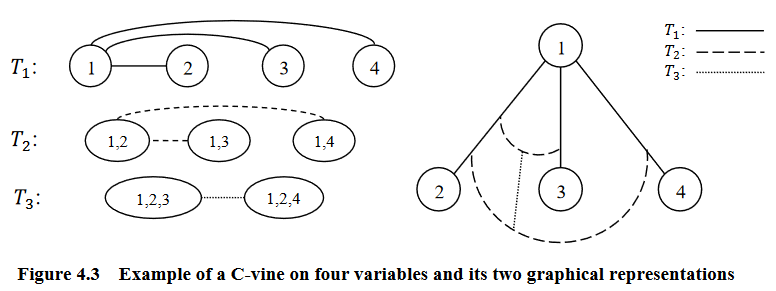

In [4]:
Image(filename='images/c_vine_example.png')

#### D-Vines

An R-vine is considered a D-vine if each node in $T_1$ has a degree of at most 2.

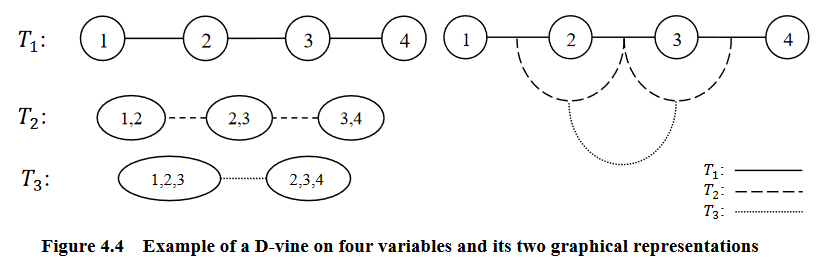

In [5]:
Image(filename='images/d_vine_example.png')

#### Partial Correlation Vines

Partial correlation measures the degree of association between two random variables while controlling for a third random variable.
It is used to find the variance between two variables while eliminating the variance from the third variable.

A partial correlation vine can be formed with an R-vine, C-vine, or D-vine structure $V$. Each edge of the vine
is identified with a partial correlation coefficient. Thus each edge in $V$ has can have a value in [-1, 1].
$V$ specifies ${d \choose 2}$ standard and partial correlations.


#### Correlation Matrices Generation

Now we are ready to know how to generate correlation matrices using the above methods.

##### Correlation Matrices using the D-vines Method

In his work, Joe (2008) shows that by using a D-vine, we can generate a $d$-dimensional random positive definite correlation matrix $R = (\rho_{i, j})$ by
choosing independent distributions $F_{i, j}, 1 \leq i < j \leq d$, for these ${d \choose 2}$ parameters.
$F_{i, j}$ conditions are chosen so that the joint density of $(\rho_{i, j})$ is proportional to a
power of $det(R)$.

Joe goes on to prove one can generate $\frac{d \cdot (d-1)}{2}$ partial correlations by independently sampling from a beta distribution of different
densities, transformed to the range [-1, 1] and then convert them into raw correlations via a recursive formula. The
resulting matrix will be distributed uniformly. The partial correlations can be generated using the D-vine or C-vine methods.

When using the D-vine, the beta distribution $Beta(\alpha_i, \alpha_i)$ is sampled for $\alpha_1 = d/2, ..., \alpha_{d-2}, \alpha_{d-1}$ Where

$\alpha_{d-2} = \alpha_{d-3} - 1/2$

$\alpha_{d-1} = \alpha_{d-2} - 1/2$

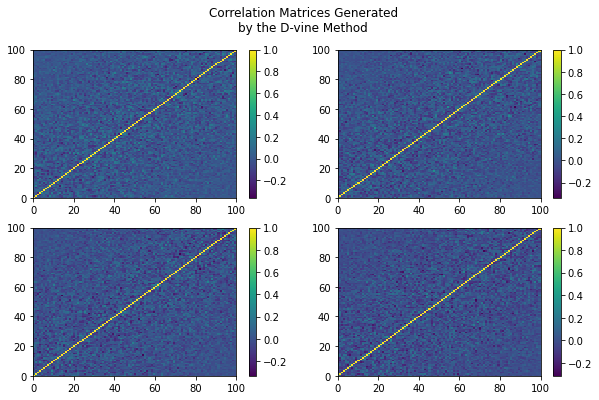

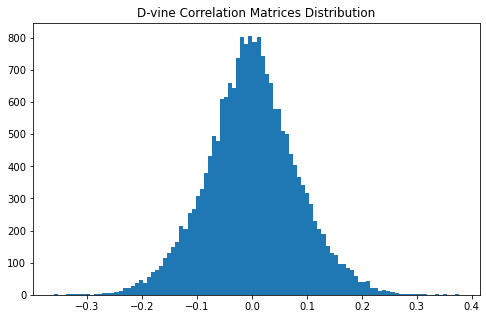

In [6]:
# Generate a correlation matrix from the D-vine method.
dim = 100
n_samples = 4
corr_mats = sample_from_dvine(dim=dim, n_samples=n_samples)

# Get the triangular matrix indices.
tri_rows, tri_cols = np.triu_indices(dim, k=1)

# Plots the correlation matrices generated in a pseudocolor plot.
plt.figure(figsize=(10, 6))
plt.suptitle("Correlation Matrices Generated\nby the D-vine Method")
for i in range(n_samples):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(corr_mats[i][:, :], cmap='viridis')
    plt.colorbar()

# Plot the distribution of correlation factors.
plt.figure(figsize=(8, 5))
plt.title("D-vine Correlation Matrices Distribution")
plt.hist(corr_mats[:, tri_rows, tri_cols].flatten(), bins=100)
plt.show()

We can appreciate the almost-normal distribution of correlation factors by using the D-vine method. By manually selecting
the beta parameters of the distribution from which the D-vine method samples from, we can force the correlations to be strongly
correlated either positively or negatively.

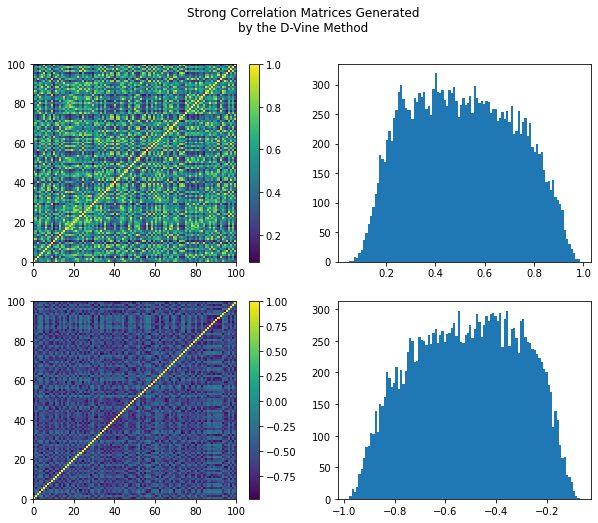

In [7]:
# Generate a correlation matrix from the D-vine method by manually settting
# the beta distribution parameters.
beta_params = [(50, 4), (4, 50)]
n_samples = 4

# Plots the correlation matrices and distributions generated.
plt.figure(figsize=(10, 8))
plt.suptitle("Strong Correlation Matrices Generated\nby the D-Vine Method")
for i, beta_param in enumerate(beta_params):
    corr_mats = sample_from_dvine(dim=dim, n_samples=n_samples, beta_dist_fixed=beta_param)
    # Plot it.
    plt.subplot(2, 2, i*2 + 1)
    plt.pcolormesh(corr_mats[0][:, :], cmap='viridis')
    plt.colorbar()
    plt.subplot(2, 2, i*2 + 2)
    plt.hist(corr_mats[:, tri_rows, tri_cols].flatten(), bins=100)

##### Correlation Matrices using the C-vines Method

Lewandowski, Kurowicka, and Joe (2009) extended the D-vine method for the C-vine. They introduce the paramater $\eta$ to sample
from a distribution proportional to $det(R)^{\eta-1}$. The resulting beta distribution $Beta(\alpha_i, \alpha_i)$ is sampled
for $\alpha_1 = \eta+ (d-1)/2, ..., \alpha_{d-2}, \alpha_{d-1}$ Where

$\alpha_{d-2} = \alpha_{d-3} - 1/2$

$\alpha_{d-1} = \alpha_{d-2} - 1/2$

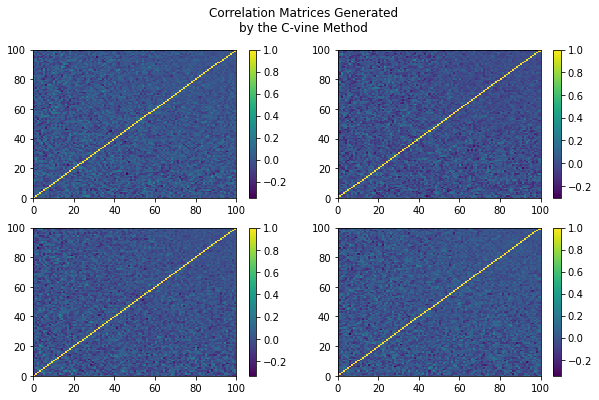

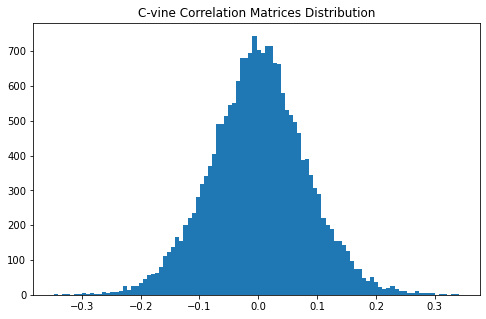

In [8]:
# Generate a correlation matrix from the C-vine method.
dim = 100
n_samples = 4
eta = 2
corr_mats = sample_from_cvine(dim=dim, eta=eta, n_samples=n_samples)

# Get the triangular matrix indices.
tri_rows, tri_cols = np.triu_indices(dim, k=1)

# Plots the correlation matrices generated in a pseudocolor plot.
plt.figure(figsize=(10, 6))
plt.suptitle("Correlation Matrices Generated\nby the C-vine Method")
for i in range(n_samples):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(corr_mats[i][:, :], cmap='viridis')
    plt.colorbar()

# Plot the distribution of correlation factors.
plt.figure(figsize=(8, 5))
plt.title("C-vine Correlation Matrices Distribution")
plt.hist(corr_mats[:, tri_rows, tri_cols].flatten(), bins=100)
plt.show()

We can appreciate the distribution of correlation factors of the C-vine method is similar to the D-vine. This is
expected since the C-vine is an extension of the D-vine, with the addition of the C-vine distribution being
proportional to $\eta-1$

As with the D-vine, we can select the beta distribution parameters to generate a correlation matrix to be strongly
correlated either positively or negatively.

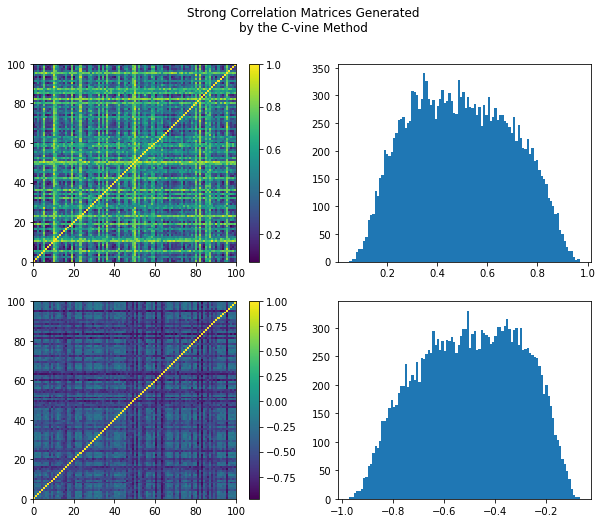

In [11]:
# Generate a correlation matrix from the C-vine method by manually settting
# the beta distribution parameters.
beta_params = [(50, 5), (5, 50)]
n_samples = 4

# Plots the correlation matrices and distributions generated.
plt.figure(figsize=(10, 8))
plt.suptitle("Strong Correlation Matrices Generated\nby the C-vine Method")
for i, beta_param in enumerate(beta_params):
    corr_mats = sample_from_cvine(dim=dim, n_samples=n_samples, beta_dist_fixed=beta_param)
    # Plot it.
    plt.subplot(2, 2, i*2 + 1)
    plt.pcolormesh(corr_mats[0][:, :], cmap='viridis')
    plt.colorbar()
    plt.subplot(2, 2, i*2 + 2)
    plt.hist(corr_mats[:, tri_rows, tri_cols].flatten(), bins=100)

## Extended Onion Method

The onion method as described by Ghosh and Henderson (2003) is a method to sample exactly and quickly from a uniform distribution. It iteratively creates a correlation matrix
by starting with a one-dimensional matrix. Then it 'grows out' the matrix by adding one dimension at a time.
Lewandowski, Kurowicka, and Joe modified this method and named it the extended onion method. The extended onion samples correlation
matrices from a distribution proportional to $det(R)^{\eta-1}$ as described above. It samples exactly from the uniform distribution
over the set of correlation matrices on the surface of a k-dimensional hypersphere, a subset of $R^{\frac{d-1}{1}}$.

The onion method is based on the fact that any correlation matrix of size $(k+1) \times (k+1)$ can be partitioned as

$
\textbf{r}_{k+1} =
$

$
\begin{bmatrix}
    \textbf{r}_{k} & \textbf{z} \\
    \textbf{z}^T & 1 \\
\end{bmatrix}
$

Where $\textbf{r}_k$ is an $k \times k$ correlation matrix and $\textbf{z}$ is a $k$-vector of correlations.

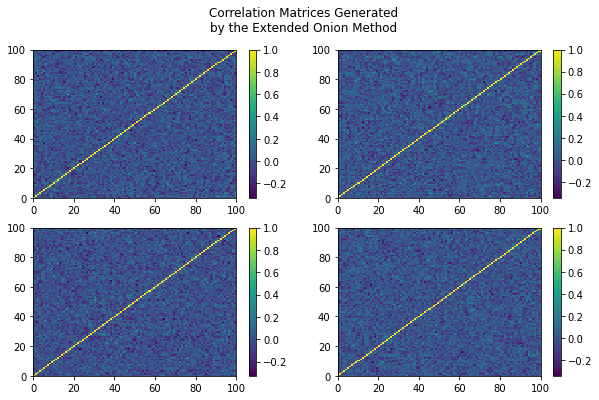

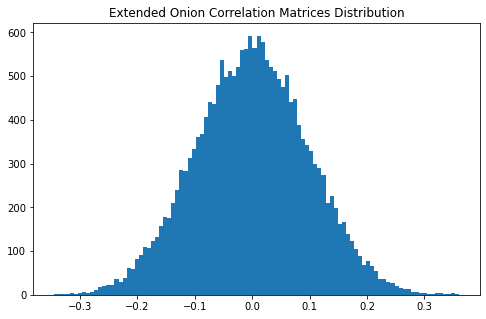

In [13]:
# Generate a correlation matrix from the extended onion method.
dim = 100
n_samples = 4
eta = 2
corr_mats = sample_from_ext_onion(dim=dim, eta=eta, n_samples=n_samples)

# Get the triangular matrix indices.
tri_rows, tri_cols = np.triu_indices(dim, k=1)

# Plots the correlation matrices generated in a pseudocolor plot.
plt.figure(figsize=(10, 6))
plt.suptitle("Correlation Matrices Generated\nby the Extended Onion Method")
for i in range(n_samples):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(corr_mats[i][:, :], cmap='viridis')
    plt.colorbar()

# Plot the distribution of correlation factors.
plt.figure(figsize=(8, 5))
plt.title("Extended Onion Correlation Matrices Distribution")
plt.hist(corr_mats[:, tri_rows, tri_cols].flatten(), bins=100)
plt.show()

## Performance

It should be noted that the higher the dimension to generate, the longer it takes to compute. For a machine with the following specifications,
we show a table with average run times for several dimensions.

<b>Specifications</b>: <br>
<b>OS</b>: Windows 10 10.0.18362 N/A Build 18362 <br>
<b>Processor</b>: Intel64 Family 6 Model 158 Stepping 12 GenuineIntel ~3600 Mhz <br>
<b>GPU</b>: None <br>
<b>RAM</b>: 32 GB



| Dimension | Number of<br>Samples | Avg Time 20 runs<br>D-Vine (seconds) | Avg Time 20 runs<br>C-Vine (seconds) | Avg Time 20 runs<br>Ext Onion (seconds) |
|:---------:|:--------------------:|:------------------------------------:|:------------------------------------:|:---------------------------------------:|
|     10    |           1          |                0.0004                |                0.0004                |                  0.0005                 |
|           |          10          |                 0.004                |                 0.004                |                  0.005                  |
|           |          100         |                 0.039                |                 0.037                |                  0.005                  |
|           |         1000         |                 0.39                 |                 0.37                 |                   0.48                  |
|     20    |           1          |                 0.003                |                 0.003                |                  0.0015                 |
|           |          10          |                 0.03                 |                 0.03                 |                  0.015                  |
|           |          100         |                 0.33                 |                 0.32                 |                  0.147                  |
|           |         1000         |                 3.36                 |                 3.21                 |                   1.44                  |
|     30    |           1          |                 0.011                |                0.0108                |                  0.003                  |
|           |          10          |                 0.11                 |                 0.107                |                  0.033                  |
|           |          100         |                 1.12                 |                 1.07                 |                   0.33                  |
|     50    |           1          |                 0.05                 |                 0.05                 |                  0.012                  |
|           |          20          |                 1.08                 |                 1.03                 |                   0.25                  |
|           |          40          |                 2.11                 |                 2.01                 |                   0.5                   |
|     80    |           1          |                 0.23                 |                 0.21                 |                   0.06                  |
|           |          10          |                 2.29                 |                 2.10                 |                   0.58                  |
|    100    |           1          |                 0.44                 |                 0.41                 |                   0.15                  |
|           |           5          |                 2.21                 |                 2.04                 |                   0.74                  |
|    200    |           1          |                 3.52                 |                 3.35                 |                   2.66                  |
|           |           5          |                 17.2                 |                 16.47                |                  13.18                  |

## Conclusion

In this notebook, we showed how to generate correlation matrices from the C-vine, D-vine, and extended onion methods in the mlfinlab package.
We found that:

1. We can generate correlation matrices that have less than 200 dimensions in less than a second.
2. In general, the extended onion method is faster than the vine methods, with the exception of dimension = 10
3. The generated correlation factors of the matrices have an almost-normal distribution. We demonstrated we can generate
stronger positive or negative correlations by manually selecting the beta distribution parameters from which the generating
methods sample.

[references]: #references
## References
1. [Lewandowski, D., Kurowicka, D. and Joe, H., 2009. Generating random correlation matrices based on vines and extended onion method. _Journal of multivariate analysis, 100_(9), pp.1989-2001.](https://www.sciencedirect.com/science/article/pii/S0047259X09000876)
<br>
2. [Joe, H., 2006. Generating random correlation matrices based on partial correlations. _Journal of Multivariate Analysis, 97_(10), pp.2177-2189.](https://www.sciencedirect.com/science/article/pii/S0047259X05000886)
<br>
3. [Zhu, Z. and Welsch, R.E., 2018. Robust dependence modeling for high-dimensional covariance matrices with financial applications. _The Annals of Applied Statistics, 12_(2), pp.1228-1249.](https://pdfs.semanticscholar.org/9c8d/214a91833e4f8727050f6af783a578f9f6e7.pdf)